In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time
import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv
import os

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from tqdm import tqdm_notebook, tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

![image](https://github.com/Lexie88rus/Bengali_AI_Competition/raw/master/assets/samples.png)

# Bengali.AI Resnet CutMix

## Load Data

Specify the path to data and load the csv files:

In [2]:
# setup the input data folder
DATA_PATH = './data/'
PREPROCESSED_PATH = './preprocessed64/'

# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [3]:
train_labels.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
HOST = "app.verta.ai"

PROJECT_NAME = "BengaliAI"
EXPERIMENT_NAME = "Resnext50"

In [5]:
os.environ['VERTA_EMAIL'] = 'astakhova.aleksandra@gmail.com'
os.environ['VERTA_DEV_KEY'] = 'd7ee32b5-bbd0-4c4c-a2ec-a070848021be'

In [6]:
from verta import Client
from verta.utils import ModelAPI

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run()

run.log_tag('Resnet50')
run.log_tag('cifar')
run.log_tag('added more transforms')

set email from environment
set developer key from environment
connection successfully established
set existing Project: BengaliAI
created new Experiment: Resnext50
created new ExperimentRun: Run 772015828712946153197


## Image Preprocessing and Data Augmentation

Preprocessing and data augmentation are exteremely important for the training of deep learning models. I use the adaptive thresholding to binarize the input images and a simple data augmentation pipeline consisting of random crop-resize and slight rotation of the input images.

In [7]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

SIZE = 64

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        albu.RandomSizedCrop(min_max_height=(int(SIZE // 1.1), SIZE), height = SIZE, width = SIZE, p=p),
        # compose the random cropping and random rotation
        albu.Rotate(limit=3, p=p),
    ], p=1.0)

def valid_transforms():
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.CenterCrop(height = 128, width = 128),
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

## Define the Dataset

The next step is to create a custom pytorch dataset, which will produce images and corresponding labels out of the traing dataset:

In [8]:
'''
Helper functions to retrieve the images from the dataset in training and validation modes
'''

def get_image(idx, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = labels.iloc[idx].image_id
    filename = PREPROCESSED_PATH + str(image_id) + '.png' 
    # get the image by id
    img = np.asarray(PIL.Image.open(filename))
    # get the labels
    row = labels[labels.image_id == image_id]
    
    # return labels as tuple
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, labels):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = labels.iloc[idx].image_id
    # get the image by id
    filename = PREPROCESSED_PATH + str(image_id) + '.png' 
    # get the image by id
    img = np.asarray(PIL.Image.open(filename))
    return img, image_id

In [9]:
class BengaliDataset(Dataset):
    '''
    Create a custom Bengali images dataset
    '''
    def __init__(self, transforms, df_labels = None, validation = False):
        '''
        Init function
        INPUT:
            df_images - dataframe with the images
            transforms - data transforms
            df_labels - datafrane containing the target labels
            validation - flag indication if the dataset is for training or for validation
        '''
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_labels)

    def __getitem__(self, idx):
        if not self.validation:
            # get the image
            img, label = get_image(idx, self.df_labels)
            # transform the image
            aug = self.transforms(image = img)
            img = TF.to_tensor(aug['image'])
            #img = np.tile(img, (3,1,1))
            return img, label
        else:
            # get the image
            img, image_id = get_validation(idx, self.df_labels)
            # transform the image
            #img = np.tile(img, (3,1,1))
            return img, image_id

Now let's check that everything is correct. Let's try to retrieve couple of images from the dataset:

In [10]:
# initialize train dataset
train_dataset = BengaliDataset(train_transforms(), train_labels)
# create a sample trainloader
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

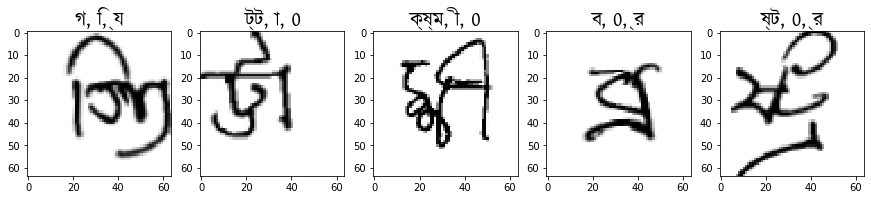

In [11]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i][0].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[i].set_title('{}, {}, {}'.format(grapheme_root, vowel_diacritic, consonant_diacritic), 
                         fontproperties=prop, fontsize=20)
    break;

## Define the Model

In [14]:
"""
https://arxiv.org/abs/1611.05431
official code:
https://github.com/facebookresearch/ResNeXt
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

from torch.autograd import Variable

class ResBottleBlock(nn.Module):
    
    def __init__(self, in_planes, bottleneck_width=4, stride=1, expansion=1):
        super(ResBottleBlock, self).__init__()
        self.conv0=nn.Conv2d(in_planes,bottleneck_width,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(bottleneck_width)
        self.conv1=nn.Conv2d(bottleneck_width,bottleneck_width,3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(bottleneck_width)
        self.conv2=nn.Conv2d(bottleneck_width,expansion*in_planes,1,bias=False)
        self.bn2=nn.BatchNorm2d(expansion*in_planes)
        
        self.shortcut=nn.Sequential()
        if stride!=1 or expansion!=1:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_planes,in_planes*expansion,1,stride=stride,bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BasicBlock_A(nn.Module):
    def __init__(self, in_planes, num_paths=32, bottleneck_width=4, expansion=1, stride=1):
        super(BasicBlock_A,self).__init__()
        self.num_paths = num_paths
        for i in range(num_paths):
            setattr(self,'path'+str(i),self._make_path(in_planes,bottleneck_width,stride,expansion))

        # self.paths=self._make_path(in_planes,bottleneck_width,stride,expansion)
        self.conv0=nn.Conv2d(in_planes*expansion,expansion*in_planes,1,stride=1,bias=False)
        self.bn0 = nn.BatchNorm2d(in_planes * expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or expansion != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, in_planes * expansion, 1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = self.path0(x)
        for i in range(1,self.num_paths):
            if hasattr(self,'path'+str(i)):
                out+getattr(self,'path'+str(i))(x)
            # out+=self.paths(x)
            # getattr
        # out = torch.sum(out, dim=1)
        out = self.bn0(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    def _make_path(self, in_planes, bottleneck_width, stride, expansion):
        layers = []
        layers.append(ResBottleBlock(
            in_planes, bottleneck_width, stride, expansion))
        return nn.Sequential(*layers)

class BasicBlock_C(nn.Module):
    """
    increasing cardinality is a more effective way of 
    gaining accuracy than going deeper or wider
    """

    def __init__(self, in_planes, bottleneck_width=4, cardinality=32, stride=1, expansion=2):
        super(BasicBlock_C, self).__init__()
        inner_width = cardinality * bottleneck_width
        self.expansion = expansion
        self.basic = nn.Sequential(OrderedDict(
            [
                ('conv1_0', nn.Conv2d(in_planes, inner_width, 1, stride=1, bias=False)),
                ('bn1', nn.BatchNorm2d(inner_width)),
                ('act0', nn.ReLU()),
                ('conv3_0', nn.Conv2d(inner_width, inner_width, 3, stride=stride, padding=1, groups=cardinality, bias=False)),
                ('bn2', nn.BatchNorm2d(inner_width)),
                ('act1', nn.ReLU()),
                ('conv1_1', nn.Conv2d(inner_width, inner_width * self.expansion, 1, stride=1, bias=False)),
                ('bn3', nn.BatchNorm2d(inner_width * self.expansion))
            ]
        ))
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != inner_width * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, inner_width * self.expansion, 1, stride=stride, bias=False)
            )
        self.bn0 = nn.BatchNorm2d(self.expansion * inner_width)

    def forward(self, x):
        out = self.basic(x)
        out += self.shortcut(x)
        out = F.relu(self.bn0(out))
        return out
    
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, expansion=2, num_classes=500):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64
        self.expansion = expansion
        
        self.conv0 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(self.in_planes)
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1=self._make_layer(num_blocks[0],1)
        self.layer2=self._make_layer(num_blocks[1],2)
        self.layer3=self._make_layer(num_blocks[2],2)
        self.layer4=self._make_layer(num_blocks[3],2)
        self.linear = nn.Linear(self.cardinality * self.bottleneck_width, num_classes)

    def forward(self, x):
        out = F.relu(self.bn0(self.conv0(x)))
        # out = self.pool0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock_C(self.in_planes, self.bottleneck_width, self.cardinality, stride, self.expansion))
            self.in_planes = self.expansion * self.bottleneck_width * self.cardinality
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)
    
def resnext26_2x64d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=2, bottleneck_width=64)


def resnext26_4x32d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=4, bottleneck_width=32)


def resnext26_8x16d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=8, bottleneck_width=16)


def resnext26_16x8d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=16, bottleneck_width=8)


def resnext26_32x4d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext26_64x2d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=32, bottleneck_width=4)


def resnext50_2x64d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=2, bottleneck_width=64)


def resnext50_32x4d():
    return ResNeXt(num_blocks=[3, 4, 6, 3], cardinality=32, bottleneck_width=4)

In [15]:
backbone_model = resnext50_2x64d()

In [16]:
'''
Custom model for the Bengali images
backbone model may be replaced with any other archirtecture :)
'''

class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=500, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=500, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=500, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        y = self.conv(x)
        y = self.pool(y)
        
        y = self.backbone_model(y)
        
        # multi-output
        grapheme_root = self.fc1(y)
        vowel_diacritic = self.fc2(y)
        consonant_diacritic = self.fc3(y)
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [17]:
# initialize the final model
model = BengaliModel(backbone_model)

## Train the Model

Now we are all set for the modelling:

First, let's start with defining the hyperparameters. In this notebook I won't be actually training the model, that is why the number of epochs is 0. I trained the model on my own machine and will just load the weights here.

In [18]:
test_split = 0.2
batch_size = 128
epochs = 50 # change this value to actually train the model
learning_rate = 0.001
num_workers = 0

In [19]:
run.log_hyperparameter("test_split", test_split)
run.log_hyperparameter("batch_size", batch_size)
run.log_hyperparameter("epochs", epochs)
run.log_hyperparameter("learning_rate", learning_rate)
run.log_hyperparameter("image_size", SIZE)

Setup the dataset and samplers:

In [20]:
dataset_size = len(train_dataset)

# split the dataset into test and train
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=32, sampler=test_sampler, num_workers=num_workers)

Optimizer and loss function:

In [21]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [22]:
run.log_hyperparameter("optimizer", "Adam")
run.log_hyperparameter("loss", "CrossEntropyLoss")

Define a training device:

In [23]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Setup the logging. I will write the log into pandas DataFrame.

In [24]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

Now we are ready to train! 

In [25]:
#state = torch.load('resnet50_cutmix_64_transforms_stopped_50.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(state["state_dict"])

In [26]:
# move the model to the training device
model = model.to(device)

Training loop:

In [27]:
def adjust_learning_rate(optimizer, epoch, learning_rate, epochs):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.1 ** (epoch // (epochs * 0.5))) * (0.1 ** (epoch // (epochs * 0.75)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def get_learning_rate(optimizer):
    lr = []
    for param_group in optimizer.param_groups:
        lr += [param_group['lr']]
    return lr

In [28]:
def get_accuracy(ps, labels):
    '''
    Helper function to calculate the accuracy given the labels and the output of the model
    '''
    ps = torch.exp(ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in tqdm_notebook(trainloader):
        steps += 1
        # move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        # forward pass
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        
        # calculate the loss
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # get the average accuracy
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
        
        adjust_learning_rate(optimizer, epoch, learning_rate, epochs)
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    # run validation on the test set
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), [label.to(device) for label in labels]
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()
            
            scheduler.step(test_loss)

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
    
    # print out the training stats
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")
    
    filename = 'resnext_'+ str(epoch+1) + '.pth'
    checkpoint = {'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)
    
    run.log_observation("time_per_epoch", time_elapsed)
    run.log_observation("time_per_step", time_elapsed/len(trainloader))
    run.log_observation("train_loss", running_loss/len(trainloader))
    run.log_observation("test_loss", test_loss/len(testloader))
    run.log_observation("train_accuracy", train_accuracy/len(trainloader))
    run.log_observation("test_accuracy", test_accuracy/len(testloader))
    run.log_observation("learning_rate", learning_rate)

    # write to the training log
    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    steps = 0
    model.train()

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.00 GiB total capacity; 3.93 GiB already allocated; 27.93 MiB free; 53.55 MiB cached)

In [ ]:
filename = 'resnext_'+ str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [ ]:
train_stats.to_csv('resnext_train_stats_1_{}.csv'.format(epochs))

In [ ]:
run.log_dataset('model', checkpoint)

In [ ]:
run.log_dataset('train_stats', train_stats)

## Analyze Results

Now we can look at the training results:

In [ ]:
# plot the loss
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()
run.log_image("loss", plt)
plt.show()

In [ ]:
# plot the accuracy
plt.plot(train_stats['Train accuracy'], label='train')
plt.plot(train_stats['Test accuracy'], label='test')
plt.title('Accuracy over epoch')
plt.legend()
run.log_image("accuracy", plt)
plt.show()

Let's also visualize some sample predictions from the train set:

In [ ]:
# plot sample train data
model.eval()
for img, labels in testloader:
    img, labels = img.to(device), [label.to(device) for label in labels]
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(img)
    
    img = img.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # visualize the inputs
    fig, axs = plt.subplots(4, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(TF.to_pil_image(img[i].reshape(HEIGHT, WIDTH)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
        grapheme_root_str = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic_str = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic_str = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[0].set_title('{}, {}, {}'.format(grapheme_root_str, vowel_diacritic_str, consonant_diacritic_str), 
                         fontproperties=prop, fontsize=20)
        
        # analyze grapheme root prediction
        ps_root = F.softmax(grapheme_root[i])
        top10_p, top10_class = ps_root.topk(10, dim=0)
        
        top10_p = top10_p.detach().numpy()
        top10_class = top10_class.detach().numpy()
        
        axs[1].bar(range(len(top10_p)), top10_p)
        axs[1].set_xticks(range(len(top10_p)))
        axs[1].set_xticklabels(top10_class)
        axs[1].set_title('grapheme_root: {}'.format(labels[0][i]))
        
        # analyze vowel prediction
        ps_vowel = F.softmax(vowel_diacritic[i])
        top11_p, top11_class = ps_vowel.topk(11, dim=0)
        
        top11_p = top11_p.detach().numpy()
        top11_class = top11_class.detach().numpy()
        
        axs[2].bar(range(len(top11_p)), top11_p)
        axs[2].set_xticks(range(len(top11_p)))
        axs[2].set_xticklabels(top11_class)
        axs[2].set_title('vowel_diacritic: {}'.format(labels[1][i]))
        
        # analyze consonant prediction
        ps_cons = F.softmax(consonant_diacritic[i])
        top7_p, top7_class = ps_cons.topk(7, dim=0)
        
        top7_p = top7_p.detach().numpy()
        top7_class = top7_class.detach().numpy()
        
        axs[3].bar(range(len(top7_p)), top7_p)
        axs[3].set_xticks(range(len(top7_p)))
        axs[3].set_xticklabels(top7_class)
        axs[3].set_title('consonant_diacritic: {}'.format(labels[2][i]))
        
        plt.show()
        break;
        
    break;

## Create Submission

The last step is to create a submission:

In [ ]:
# initialize train dataset
test_dataset = BengaliDataset(test, valid_transforms(), test_labels, validation = True)
sample_validloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

Take a look at the images from validation set:

In [ ]:
# plot sample train data
for img, image_ids in sample_validloader:
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        axs[i].set_title(image_ids[i])
    break;

Create the submission:

In [ ]:
validloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
def get_predicted_label(ps):
    '''
    Helper function to get the predicted label given the probabilities from the model output
    '''
    ps = F.softmax(ps)[0]
    top_p, top_class = ps.topk(1, dim=0)
        
    top_p = top_p.detach().numpy()
    top_class = top_class.detach().numpy()
    
    return top_class[0]

In [ ]:
# create the submission
# initialize the dataframe
submission = pd.DataFrame(columns=['row_id', 'target'])

for imgs, image_ids in validloader:
    img = imgs[0]
    image_id = image_ids[0]
    
    imgs = imgs.to(device)
    
    # forward pass to get the output
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(imgs)
    
    imgs = imgs.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # get the predicted labels
    grapheme_root_label = get_predicted_label(grapheme_root)
    vowel_diacritic_label = get_predicted_label(vowel_diacritic)
    consonant_diacritic_label = get_predicted_label(consonant_diacritic)
    
    # add the results to the dataframe
    submission = submission.append({'row_id':str(image_id)+'_grapheme_root', 'target':grapheme_root_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_vowel_diacritic', 'target':vowel_diacritic_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_consonant_diacritic', 'target':consonant_diacritic_label}, 
                                   ignore_index=True)

Look at the submission file:

In [ ]:
submission.head()

In [ ]:
submission.to_csv('submission.csv')

## Conclusion

In this notebook I created and trained a sample model. This code can't be used for the actual predcitions for the competition. It requires a lot of optiomization, but you can use it as a sample for learning purposes.

## References
1. [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf)
2. [efficientnet-pytorch pacckage](https://pypi.org/project/efficientnet-pytorch/)
3. [My EDA notebook for Bengali.AI](https://www.kaggle.com/aleksandradeis/bengali-ai-eda)